# TinySpeak

En este cuaderno se crea y evalua el modelo TinyListener que es capaz de clasificar los embeddings que vienen de wav2vec2.

## 📦 Configuración

Acá se importan las librerías necesarias para trabajar con datos, construir modelos y hacer visualizaciones. Si alguna no está instalada, habría que hacerlo antes de correr esta celda.

In [ ]:
import os, subprocess, io, random, math
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.nn import  Module, LSTM, Linear, CrossEntropyLoss
import torchaudio
import numpy as np
from transformers import Wav2Vec2Model, Wav2Vec2Config, Wav2Vec2FeatureExtractor
import collections, string
import torchvision
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import Audio

### Funciones utilitarias

In [ ]:
def synthesize_word(word, voice="es", rate=80, pitch=70, amplitude=120):
    cmd = [
        "espeak",
        "-v", voice,
        "-s", str(rate),
        "-p", str(pitch),
        "-a", str(amplitude),
        "--stdout",
        word
    ]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    wav_bytes, _ = proc.communicate()
    with io.BytesIO(wav_bytes) as buf:
        waveform = load_waveform(buf)
    return waveform

def load_waveform(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    waveform = waveform.squeeze()
    if sample_rate != wav2vec_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=wav2vec_sr)
        waveform = resampler(waveform)
    return waveform

def extract_hidden_activations(waveforms):
    B = len(waveforms)
    padded = pad_sequence(waveforms, batch_first=True).to(device)
    lengths = torch.tensor([w.size(0) for w in waveforms], device=device)
    arange = torch.arange(padded.size(1), device=device)
    mask = (arange.unsqueeze(0) < lengths.unsqueeze(1)).long()
    wav2vec_model.eval()
    with torch.no_grad():
        out = wav2vec_model(padded, attention_mask=mask)
    return torch.stack(out.hidden_states, dim=0)

def mask_hidden_activations(hidden_activations, energies=None, thresholds=None):
    hidden = hidden_activations[wav2vec_target_layer]  # → (B, T_hidden, D)

    B, T_hidden, D = hidden.shape
    device = hidden.device

    if energies is not None and thresholds is not None:
        E = energies.to(hidden.device)
        th = thresholds.to(hidden.device)
        E_aligned = F.interpolate(E.unsqueeze(1), size=hidden.size(1),
                                  mode='linear', align_corners=False).squeeze(1)
        mask = (E_aligned > th[:, None])             # (B, T), bool
        voiced_seqs = [
            hidden[i][mask[i]]                       # shape: (n_i, D)
            for i in range(hidden.size(0))
        ]
        padded_hidden = pad_sequence(voiced_seqs, batch_first=True)
        lengths = torch.tensor([vs.size(0) for vs in voiced_seqs],
                               dtype=torch.long,
                               device=hidden.device)
        return padded_hidden.unsqueeze(0), lengths
    else:
        # if no VAD info provided, treat all frames as valid
        lengths = torch.full((B,), T_hidden, dtype=torch.long, device=device)

    # re-introduce the “layer” dim to match original output shape
    return hidden.unsqueeze(0), lengths

def downsample_hidden_activations(hidden_activations, lengths, factor=7):
  B, L, N, D = hidden_activations.shape
  N_target = N // factor
  hidden_activations = hidden_activations.reshape(B * L, N, D).transpose(1, 2)
  hidden_activations = F.interpolate(hidden_activations, size=N_target, mode="linear", align_corners=False)  # (B*L, F, target_n)
  hidden_activations = hidden_activations.transpose(1, 2).reshape(B, L, N_target, D)
  lengths = torch.div(lengths, factor, rounding_mode='floor')
  return hidden_activations, lengths

def short_time_energy(waveforms, threshold_ratio = 0.2):
    hop = int(round(wav2vec_sr / (wav2vec_hz / 7)))
    frames = waveforms.unfold(dimension=1, size=hop, step=hop)
    energies = frames.pow(2).sum(dim=-1)  # → (B, num_frames)
    thresholds = energies.max(dim=1).values * threshold_ratio
    return energies, thresholds

def collate_fn(batch):
    waveforms, labels = zip(*batch)
    padded_waveforms = pad_sequence(waveforms, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_waveforms, labels

def train_net(net, num_epochs, criterion, optimizer, train_loader, val_loader):
  # Instancia arreglos que contendrán información del entrenamiento
  train_losses = []
  train_accuracies = []

  # Instancia arreglos que contendrán información de la validación
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    # Entrenamiento
    net.train()

    # Acumuladores para promediar al final
    running_loss = 0.0
    running_correct = 0

    for embeddings, labels in train_loader:
      embeddings = embeddings.to(device)
      labels = labels.to(device)

      # Ponemos a cero los gradientes del optimizador
      optimizer.zero_grad()

      # Pasada hacia adelante
      logits, _ = net(embeddings)

      # Calculamos la pérdida
      loss = criterion(logits, labels)

      # Calculamos la efectividad
      predicted_classes = logits.argmax(dim=-1)
      running_correct += (predicted_classes == labels).sum().item()

      # Guardamos los resultados para análisis posterior
      running_loss += loss.item()

      # Backpropagation: actualizamos los pesos según la pérdida
      loss.backward()
      optimizer.step()

    # Guardamos los promedios por época
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_correct / len(train_loader.dataset))

    # Validación (no se actualizan pesos)
    net.eval()

    # Acumuladores para promediar al final
    running_loss = 0.0
    running_correct = 0

    with torch.no_grad():
      for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        # Pasada hacia adelante
        logits, _ = net(embeddings)

        # Calculamos la pérdida
        loss = criterion(logits, labels)

        # Calculamos la efectividad
        predicted_classes = logits.argmax(dim=-1)
        running_correct += (predicted_classes == labels).sum().item()

        # Acumulamos para promediar al final
        running_loss += loss.item()

      # Guardamos resultados de validación
      val_losses.append(running_loss / len(val_loader))
      val_accuracies.append(running_correct / len(val_loader.dataset))

    print(f"Época {epoch+1}/{num_epochs}")

  epochs = range(1, num_epochs+1)

  plot_losses(epochs, train_losses, val_losses)
  plot_accuracies(epochs, train_accuracies, val_accuracies)

def evaluate_net(net, criterion, data_loader):
  net.eval()
  top1_correct = 0
  top3_correct = 0
  top5_correct = 0
  total = 0
  total_loss = 0.0

  with torch.no_grad():
    for embeddings, labels in data_loader:
      embeddings = embeddings.to(device)
      labels = labels.to(device)

      logits, _ = net(embeddings)
      loss = criterion(logits, labels)
      total_loss += loss.item() * labels.size(0)

      # Top-k predictions
      _, topk = logits.topk(5, dim=1)   # shape: [batch, 5]

      # Top-1
      top1_correct += (topk[:, 0] == labels).sum().item()
      # Top-3
      top3_correct += sum(l in preds for preds, l in zip(topk[:, :3], labels))
      # Top-5
      top5_correct += sum(l in preds for preds, l in zip(topk[:, :5], labels))

      total += labels.size(0)

  avg_loss = total_loss / total
  top1_acc = top1_correct / total
  top3_acc = top3_correct / total
  top5_acc = top5_correct / total

  print(f"val_loss={avg_loss:.4f}")
  print(f"top-1 acc={top1_acc:.3%}")
  print(f"top-3 acc={top3_acc:.3%}")
  print(f"top-5 acc={top5_acc:.3%}")

### Funciones de graficado

In [ ]:
def display_audio(waveform):
  B = waveform.shape[0]
  for i in range(B):pmmaciel@
def plot_activations(activations):
    global_min = -3
    global_max = 3
    num_layers = activations.size(0)
    num_embeddings = activations.size(1)
    fig, axes = plt.subplots(num_layers, num_embeddings, figsize=(8, min(3 * num_layers, 12)), sharex=True, sharey=True, layout="constrained")
    axes = np.atleast_2d(axes)
    axes = axes.reshape(num_layers, num_embeddings)
    fig.suptitle("Activaciones ocultas")
    for row in range(num_layers):
        for col in range(num_embeddings):
            ax = axes[row, col]
            embedding = activations[row][col]
            im = ax.imshow(embedding.cpu().numpy(), cmap='coolwarm', vmin=global_min, vmax=global_max, aspect="auto")
            ax.set_xticks([0, embedding.size(1) - 1])
            ax.set_yticks([0, embedding.size(0) - 1])
    fig.supylabel("Ventana")
    fig.supxlabel("Dimensión")
    fig.colorbar(im, ax=axes[:])
    plt.show()

def plot_short_time_energy(energies, thresholds):
    hop = int(round(wav2vec_sr / wav2vec_hz))
    B = energies.size(0)
    time = torch.arange(energies.size(1)) * hop / wav2vec_sr
    fig, axes = plt.subplots(B, 1, figsize=(8, 3 * B), layout="constrained")
    if B == 1:
        axes = [axes]
    for k, ax in enumerate(axes):
        energy = energies[k].cpu()
        threshold = thresholds[k].cpu()
        voice = energy > threshold
        ax.plot(time.numpy(), energy.numpy(), label="Energía")
        ax.axhline(y=threshold.item(), linestyle="--", label="Umbral")
        ax.fill_between(time.numpy(), 0, energy.numpy(), where=voice.numpy(), alpha=0.5, label="Voz")
        ax.set_title("Energía a corto plazo")
        ax.set_xlabel("Tiempo (s)")
        ax.set_ylabel("Energía")
        ax.grid(True)
        ax.legend()
    plt.show()

def plot_losses(epochs, train_losses, val_losses):
    fig = plt.figure(figsize=(8, 3), layout="constrained")
    plt.plot(epochs, train_losses, label="Entrenamiento")
    plt.plot(epochs, val_losses, label="Validación")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida durante el entrenamiento")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracies(epochs, train_accuracies, val_accuracies):
    fig = plt.figure(figsize=(8, 3), layout="constrained")
    plt.plot(epochs, train_accuracies, label="Entrenamiento")
    plt.plot(epochs, val_accuracies, label="Validación")
    plt.xlabel("Época")
    plt.ylabel("Efectividad")
    plt.title("Efectividad durante el entrenamiento")
    plt.legend()pmmaciel@
    plt.grid(True)
    plt.show()

def plot_logits(logits, words):
    values = logits.squeeze().cpu().numpy()
    order = np.argsort(values)[::-1]
    sorted_words  = [words[i] for i in order]
    sorted_values = values[order]
    fig = plt.figure(figsize=(8, 3), layout="constrained")
    plt.plot(sorted_words, sorted_values, marker='o')
    plt.title("Logits")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Clases utilitarias

In [ ]:
from torch.nn.utils.rnn import PackedSequence
from torch.utils.data import Dataset

class TinySpeakFolder(Dataset):
  def __init__(self, base_dir: str):
    self.base_dir = base_dir
    classes = [
      d for d in sorted(os.listdir(base_dir))
      if not d.startswith(".") and os.path.isdir(os.path.join(base_dir, d))
    ]
    self.words = classes
    self.class_to_idx = {word: i for i, word in enumerate(self.words)}
    self.samples = []
    for cls in classes:
      cls_dir = os.path.join(base_dir, cls)
      for fname in sorted(os.listdir(cls_dir)):
        root, ext = os.path.splitext(fname)
        if ext == '.wav' and not fname.startswith("."):
          self.samples.append((os.path.join(cls_dir, root), self.class_to_idx[cls]))

  @property
  def idx_to_class(self):
    return {v: k for k, v in self.class_to_idx.items()}

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    file_path, target = self.samples[index]
    audio_path = file_path + ".wav"
    waveform = load_waveform(audio_path)pmmaciel@
    return waveform, target

### CORnet-Z

In [ ]:
from collections import OrderedDict
from torch import nn

class Flatten(nn.Module):
  """
  Helper module for flattening input tensor to 1-D for the use in Linear modules
  """
  def forward(self, x):
    return x.view(x.size(0), -1)

class Identity(nn.Module):
  """
  Helper module that stores the current tensor. Useful for accessing by name
  """
  def forward(self, x):
    return x

class CORblock_Z(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                          stride=stride, padding=kernel_size // 2)
    self.nonlin = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.output = Identity()  # for an easy access to this block's output

  def forward(self, inp):
    x = self.conv(inp)
    x = self.nonlin(x)
    x = self.pool(x)
    x = self.output(x)  # for an easy access to this block's output
    return x


def CORnet_Z():
  model = nn.Sequential(OrderedDict([
    ('V1', CORblock_Z(3, 64, kernel_size=7, stride=2)),
    ('V2', CORblock_Z(64, 128)),
    ('V4', CORblock_Z(128, 256)),
    ('IT', CORblock_Z(256, 512)),
    ('decoder', nn.Sequential(OrderedDict([
      ('avgpool', nn.AdaptiveAvgPool2d(1)),
      ('flatten', Flatten()),
      ('linear', nn.Linear(512, 1000)),
      ('output', Identity())
    ])))
  ]))

  # weight initialization
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
          nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
      m.weight.data.fill_(1)
      m.bias.data.zero_()

  return model

## 🧹 Preparación del entorno

Se configuran algunas opciones para reproducibilidad y manejo de datos. También se asegura que los dispositivos estén bien definidos (como la GPU si se está usando una).

In [ ]:
def encontrar_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  print("Device encontrado:", device)
  return device

# Dispositivo (puede ser "cpu", "cuda" o "mps")
device = encontrar_device()

# Modelo Wav2Vec2 pre-entrenado
wav2vec_model_name = "facebook/wav2vec2-base-es-voxpopuli-v2"

# Dimensiones de las capas ocultas de este modelo Wav2Vec2
wav2vec_dim = 768

# Tasa de muestreo que acepta Wav2Vec2 como entrada
wav2vec_sr = 16000

# Tasa de muestreo que devuelve Wav2Vec2 como salida
wav2vec_hz = 49

# Capa oculta de Wav2Vec2 de interés
wav2vec_target_layer = 5

# Tamaño de los lotes
batch_size = 32

letters = list(string.ascii_lowercase)

Device encontrado: cuda


In [ ]:
!pip install -q gdown

In [ ]:
from pathlib import Path
import gdown

tiny_emnist_filename = "tiny-emnist-26.tar.xz"
tiny_kalulu_filename = "tiny-kalulu-200.tar.xz"
tiny_phones_filename = "tiny-phones-200.tar.xz"
kalulu_words_filename = "kalulu-words.tar.xz"
kalulu_phonemes_filename = "kalulu-phonemes.tar.xz"

if not Path(tiny_emnist_filename).exists():
  gdown.download(id="1fRUtxB05-77koJ9ZpamWk-LWu_NP0aR8", output=tiny_emnist_filename)

if not Path(tiny_kalulu_filename).exists():
  gdown.download(id="1ItYeR5WdJVtXYbwUhbeKqvaKXGFAmN_4", output=tiny_kalulu_filename)

if not Path(tiny_phones_filename).exists():
  gdown.download(id="1V81aQxnww5nWNcDQJHbGmiijT9Lz-mgF", output=tiny_phones_filename)

if not Path(kalulu_words_filename).exists():
  gdown.download(id="1yjuRJ5vEqqqtvqdIZsRlC1eiY3J4oI0T", output=kalulu_words_filename)

if not Path(kalulu_phonemes_filename).exists():
  gdown.download(id="1gNpjFv2OTLw3zy1OfWm7rslIi3Fc8nYu", output=kalulu_phonemes_filename)


Downloading...
From (original): https://drive.google.com/uc?id=1fRUtxB05-77koJ9ZpamWk-LWu_NP0aR8
From (redirected): https://drive.google.com/uc?id=1fRUtxB05-77koJ9ZpamWk-LWu_NP0aR8&confirm=t&uuid=94896c26-f7d5-4dc6-8a7c-73d9e2ce69fa
To: /content/tiny-emnist-26.tar.xz
100%|██████████| 3.93M/3.93M [00:00<00:00, 74.0MB/s]


In [ ]:
import tarfile

data_path = Path("data")
tiny_emnist_path = data_path / "tiny-emnist-26"
tiny_kalulu_path = data_path / "tiny-kalulu-200"
tiny_phones_path = data_path / "tiny-phones-200"
kalulu_words_path = data_path / "kalulu-words"
kalulu_phonemes_path = data_path / "kalulu-phonemes"

if not tiny_emnist_path.exists():
  with tarfile.open(tiny_emnist_filename, mode="r:xz") as tar:
    tar.extractall(path=data_path)

if not tiny_kalulu_path.exists():
  with tarfile.open(tiny_kalulu_filename, mode="r:xz") as tar:
    tar.extractall(path=data_path)

if not tiny_phones_path.exists():
  with tarfile.open(tiny_phones_filename, mode="r:xz") as tar:
    tar.extractall(path=data_path)

if not kalulu_words_path.exists():
  with tarfile.open(kalulu_words_filename, mode="r:xz") as tar:
    tar.extractall(path=data_path)

if not kalulu_phonemes_path.exists():
  with tarfile.open(kalulu_phonemes_filename, mode="r:xz") as tar:
    tar.extractall(path=data_path)

/tmp/ipython-input-2939877015.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_path)


In [ ]:
for p in tiny_emnist_path.rglob("*"):
    name = p.name
    if name.startswith("._"):
        try:
            p.unlink()
            print(f"🧽 Removed: {p}")
        except Exception as e:
            print(f"⚠️ Could not remove {p}: {e}")

## 📥 Carga del dataset

En esta parte se muestra como se puede cargar el conjunto de datos *Tiny Speak*, que contiene pronunciaciones de palabras con amplitudes, velocidades y _pitchs_ diferentes. A modo de ejemplo se muestra como luce el primer item del conjunto de entrenamiento.

In [ ]:
dataset = TinySpeakFolder(tiny_kalulu_path / "val")

@widgets.interact(idx=[(f"{idx}: {dataset.idx_to_class[target]}", idx) for idx, (_, target) in enumerate(dataset)])
def display_dataset_item(idx):
  waveform, label = dataset[idx]
  waveform = waveform.unsqueeze(0)
  plot_waveform(waveform)
  display_audio(waveform)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

interactive(children=(Dropdown(description='idx', options=(('0: acto', 0), ('1: acto', 1), ('2: agua', 2), ('3…

In [ ]:
# Instancia el dataset
dataset = TinySpeakFolder(tiny_phones_path / "val")

@widgets.interact(idx=[(f"{idx}: {dataset.idx_to_class[target]}", idx) for idx, (_, target) in enumerate(dataset)])
def display_dataset_item(idx):
  waveform, label = dataset[idx]
  waveform = waveform.unsqueeze(0)
  plot_waveform(waveform)
  display_audio(waveform)

interactive(children=(Dropdown(description='idx', options=(('0: acto', 0), ('1: acto', 1), ('2: agua', 2), ('3…

## 🧭 Exploración del modelo

In [ ]:
config = Wav2Vec2Config.from_pretrained(wav2vec_model_name)
config.output_hidden_states = True
wav2vec_model = Wav2Vec2Model.from_pretrained(wav2vec_model_name,  config=config)
wav2vec_model = wav2vec_model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

### 🎯 Extracción de embeddings en una capa relevante

En esta sección nos enfocamos en los **embeddings** de la capa configurada por `wav2vec_target_layer`. Tomamos las activaciones de la capa elegida. De este modo, podemos identificar patrones espaciales más finos y comparar cómo se distribuyen los valores en bloques locales del vector.

In [ ]:
dataset = TinySpeakFolder(tiny_kalulu_path / "val")

@widgets.interact(idx=[(f"{idx}: {dataset.idx_to_class[target]}", idx) for idx, (_, target) in enumerate(dataset)])
def display_dataset_item(idx):
  waveform, label = dataset[idx]
  display(Audio(data=waveform, rate=wav2vec_sr))
  waveform = waveform.unsqueeze(0)
  plot_waveform(waveform)
  hidden_activations = extract_hidden_activations(waveform)
  hidden_activations, lengths = mask_hidden_activations(hidden_activations)
  hidden_activations, lengths = downsample_hidden_activations(hidden_activations, lengths, factor=7)
  plot_activations(hidden_activations)

interactive(children=(Dropdown(description='idx', options=(('0: acto', 0), ('1: acto', 1), ('2: agua', 2), ('3…

## 🧠 Definición del modelo

Acá se define la arquitectura de la red neuronal. Es una red simple, pero suficiente para experimentar con reconocimiento de palabras. A modo de ejemplo se muestra como luce la arquitectura de una instancia de la red.

In [ ]:
class TinySpeak(Module):
  def __init__(self, words: [str], hidden_dim=128, num_layers=2):
    super().__init__()
    self.words = words
    self.hidden_dim = hidden_dim
    self.lstm = LSTM(
      input_size=wav2vec_dim,
      hidden_size=hidden_dim,
      num_layers=num_layers,
      batch_first=True
    )
    self.classifier = Linear(hidden_dim, len(words))

  def forward(self, packed_sequence: PackedSequence) -> Tensor:
    _, (h_n, _) = self.lstm(packed_sequence)
    logits = self.classifier(h_n[-1])
    return logits, h_n

class TinyListener(Module):
  def __init__(self, tiny_speak: TinySpeak):
    super().__init__()
    self.tiny_speak = tiny_speak

  def forward(self, waveform: Tensor) -> Tensor:
    """
    waveform:       FloatTensor of shape (B, T_max, input_dim)
    lengths: LongTensor of shape (B,) with the true lengths ≤ T_max
    """
    hidden_activations = extract_hidden_activations(waveform)
    #energies, thresholds = short_time_energy(waveform, self.threshold_ratio)
    hidden_activations, lengths = mask_hidden_activations(hidden_activations)#, energies=energies, thresholds=thresholds)
    hidden_activations, lengths = downsample_hidden_activations(hidden_activations, lengths, factor=7)
    hidden_activations = hidden_activations.squeeze(0)
    # Pack the padded batch
    packed = pack_padded_sequence(
      hidden_activations, lengths.cpu(), batch_first=True, enforce_sorted=False
    )
    return tiny_speak(packed)

dataset = TinySpeakFolder(tiny_kalulu_path / "val")

tiny_speak = TinySpeak(words=dataset.words, hidden_dim=64, num_layers=2)
tiny_speak = tiny_speak.to(device)

tiny_listener = TinyListener(tiny_speak=tiny_speak)
tiny_listener = tiny_listener.to(device)

display(tiny_listener)

TinyListener(
  (tiny_speak): TinySpeak(
    (lstm): LSTM(768, 64, num_layers=2, batch_first=True)
    (classifier): Linear(in_features=64, out_features=200, bias=True)
  )
)

## 🚂 Entrenamiento del modelo

A continuación se muestra el bucle de entrenamiento y validación de TinyListener, utilizando optimizador SGD y CrossEntropyLoss. En cada época se computa la pérdida de entrenamiento, seguida de la evaluación sobre el conjunto de validación para obtener la pérdida y la precisión.

Entrenamiento en tiny-kalulu-200 por 12 épocas:
Época 1/12
Época 2/12
Época 3/12
Época 4/12
Época 5/12
Época 6/12
Época 7/12
Época 8/12
Época 9/12
Época 10/12
Época 11/12
Época 12/12


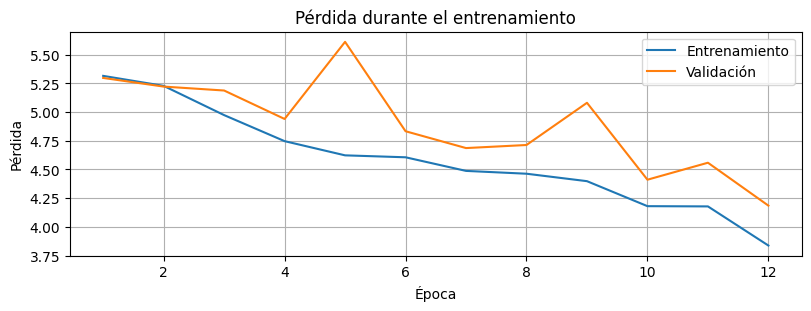

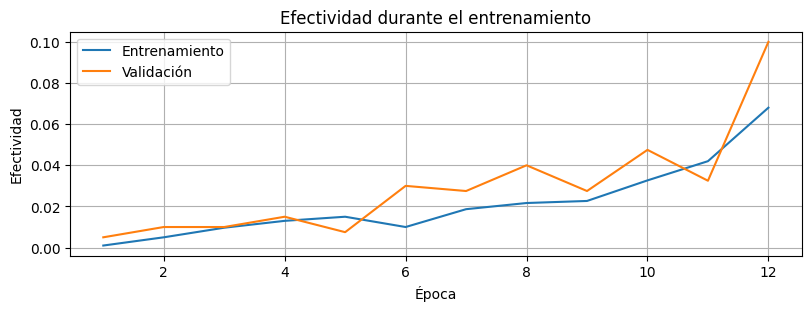

Evaluación en tiny-kalulu-200:
val_loss=4.0819
top-1 acc=10.000%
top-3 acc=23.000%
top-5 acc=30.750%
Evaluación en tiny-phones-200:
val_loss=7.7265
top-1 acc=1.500%
top-3 acc=3.500%
top-5 acc=4.750%
Entrenamiento en tiny-phones-200 por 4 épocas:
Época 1/4
Época 2/4
Época 3/4
Época 4/4


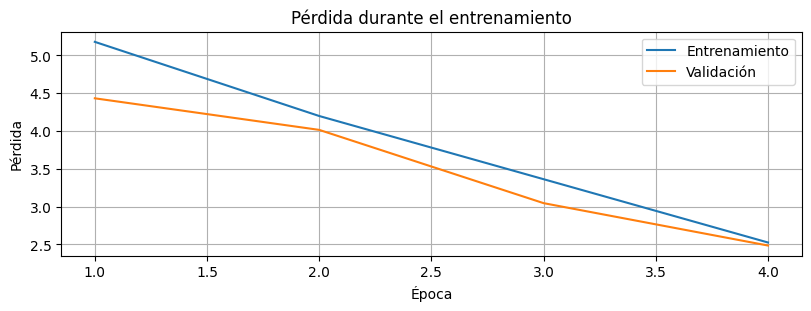

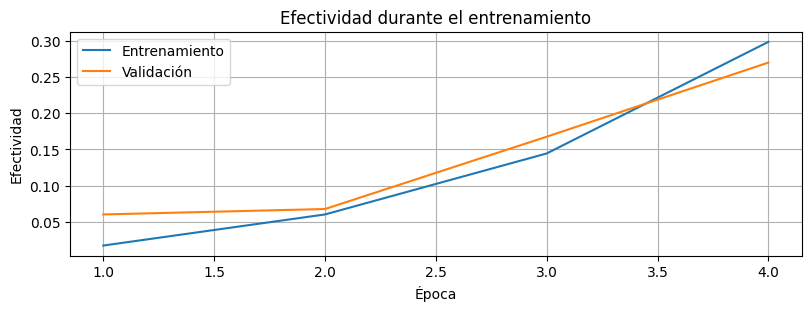

Evaluación en tiny-kalulu-200:
val_loss=7.1750
top-1 acc=0.750%
top-3 acc=3.750%
top-5 acc=4.750%
Evaluación en tiny-phones-200:
val_loss=2.5151
top-1 acc=27.000%
top-3 acc=55.750%
top-5 acc=68.000%
Entrenamiento en tiny-kalulu-200 por 2 épocas:
Época 1/2
Época 2/2


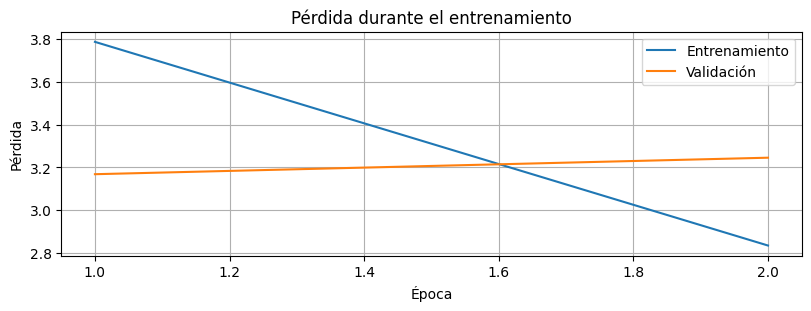

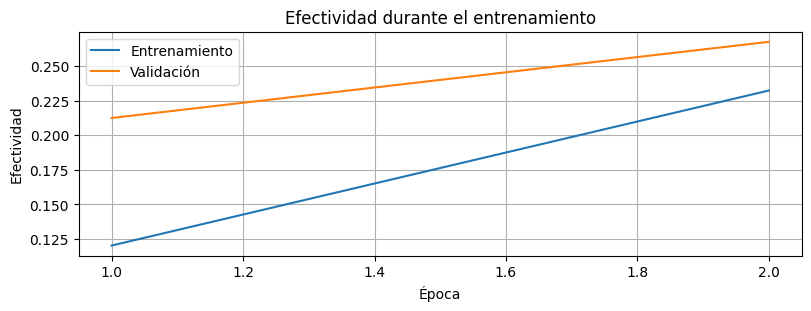

Evaluación en tiny-kalulu-200:
val_loss=3.1495
top-1 acc=26.750%
top-3 acc=43.500%
top-5 acc=55.250%
Evaluación en tiny-phones-200:
val_loss=5.8015
top-1 acc=3.000%
top-3 acc=11.000%
top-5 acc=17.000%


In [ ]:
def train_and_eval(net, dataset_name, num_epochs):
  print(f"Entrenamiento en {dataset_name} por {num_epochs} épocas:")
  # Instancia el criterio para evaluar las pérdidas
  criterion = CrossEntropyLoss()

  # Instancia el optimizador
  optimizer = SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

  # Instancia el conjunto de entrenamiento
  train_dataset = TinySpeakFolder(data_path / dataset_name / "train")
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

  # Instancia el conjunto de validación
  val_dataset = TinySpeakFolder(data_path / dataset_name / "val")
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  # Entrena el modelo
  train_net(net, num_epochs, criterion, optimizer, train_loader, val_loader)

  # Evalua el modelo en tiny-kalulu-200
  print("Evaluación en tiny-kalulu-200:")
  dataset = TinySpeakFolder(tiny_kalulu_path / "val")
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
  evaluate_net(net, CrossEntropyLoss(), loader)

  # Evalua el modelo en tiny-phones-200
  print("Evaluación en tiny-phones-200:")
  dataset = TinySpeakFolder(tiny_phones_path / "val")
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
  evaluate_net(net, CrossEntropyLoss(), loader)

words = TinySpeakFolder(tiny_kalulu_path / "val").words

tiny_speak = TinySpeak(words=words, hidden_dim=64, num_layers=2)
tiny_speak = tiny_speak.to(device)

tiny_listener = TinyListener(tiny_speak=tiny_speak)
tiny_listener = tiny_listener.to(device)

train_and_eval(tiny_listener, dataset_name="tiny-kalulu-200", num_epochs=12)
train_and_eval(tiny_listener, dataset_name="tiny-phones-200", num_epochs=4)
train_and_eval(tiny_listener, dataset_name="tiny-kalulu-200", num_epochs=2)

## Guardado del modelo

In [ ]:
torch.save(tiny_speak.state_dict(), "tiny_speak.pth")

## Carga del modelo entrenado

In [ ]:
#raise RuntimeError("Comentá esta línea para cargar los pesos de TinyListener.")

dataset = TinySpeakFolder(tiny_kalulu_path / "val")
words=dataset.words

tiny_speak = TinySpeak(words=dataset.words, hidden_dim=64, num_layers=2)
tiny_speak.load_state_dict(torch.load("tiny_speak.pth"))
tiny_speak = tiny_speak.to(device)

tiny_listener = TinyListener(tiny_speak=tiny_speak)
tiny_listener = tiny_listener.to(device)

## 🔍 Evaluación del modelo

### Palabras de Kalulu

A continuación se muestra un ejemplo de cómo extraer sus embeddings de voz a partir de un audio (de Kalulu), pasar dichos embeddings por el clasificador TinyListener y visualizar tanto la matriz de embeddings como los logits resultantes.

In [ ]:
kalulu_dataset = TinySpeakFolder(tiny_kalulu_path / "val")

@widgets.interact(idx=[(f"{idx}: {kalulu_dataset.idx_to_class[target]}", idx) for idx, (_, target) in enumerate(kalulu_dataset)])
def make_inference(idx):
    waveform, label = kalulu_dataset[idx]
    waveform = waveform.unsqueeze(0)
    energy, threshold = short_time_energy(waveform, 0.01)
    plot_short_time_energy(energy, threshold)

    waveform = waveform.to(device)
    tiny_listener.eval()
    with torch.no_grad():
        # Obtenemos la predicción
        logits, _ = tiny_listener(waveform)
    plot_logits(logits, words=kalulu_dataset.words)

interactive(children=(Dropdown(description='idx', options=(('0: acto', 0), ('1: acto', 1), ('2: agua', 2), ('3…

### Concatenación de fonemas de Kalulu

In [ ]:
phones_dataset = TinySpeakFolder(tiny_phones_path / "val")

@widgets.interact(idx=[(f"{idx}: {phones_dataset.idx_to_class[target]}", idx) for idx, (_, target) in enumerate(phones_dataset)])
def make_inference(idx):
    waveform, label = phones_dataset[idx]
    waveform = waveform.unsqueeze(0)
    plot_waveform(waveform)

    waveform = waveform.to(device)
    tiny_listener.eval()
    with torch.no_grad():
        # Obtenemos la predicción
        logits, _ = tiny_listener(waveform)
    plot_logits(logits, words=kalulu_dataset.words)

interactive(children=(Dropdown(description='idx', options=(('0: acto', 0), ('1: acto', 1), ('2: agua', 2), ('3…

# 👁️ TinyRecognizer

**TinyRecognizer** es un modelo neuronal simple diseñado para reconocer letras escritas a mano a partir de imágenes en escala de grises. Utiliza una arquitectura densa y compacta que permite:

- Procesar imágenes de baja resolución (28x28 píxeles)
- Aprender patrones visuales que diferencian letras entre sí
- Generalizar a ejemplos no vistos con un conjunto reducido de datos (Tiny EMNIST)

Este modelo sirve como una primera aproximación al reconocimiento visual en tareas cognitivas. Aunque es una red sencilla, permite observar cómo una red puede aprender representaciones útiles a partir de datos perceptuales crudos.

Además, es útil para entender el vínculo entre percepción visual y representación simbólica, un tema central en ciencias cognitivas computacionales.

### 🧠 Definición del modelo

Acá se define la arquitectura de la red neuronal. Es una red **simple pero funcional** para el reconocimiento de caracteres manuscritos.

Se muestra además como luce la arquitectura de una instancia de la red.

In [ ]:
from torch.nn import Module, Sequential, AdaptiveAvgPool2d, Flatten, Linear, ReLU, DataParallel

class TinyRecognizer(Module):
  def __init__(self):
    super().__init__()
    self.cornet = CORnet_Z()
    self.cornet.decoder = Sequential(collections.OrderedDict([
      ('avgpool', AdaptiveAvgPool2d((1, 1))),
      ('flatten', Flatten()),
      ('linear_input', Linear(512, 1024)),
      ('relu', ReLU()),
      ('linear_ouput', Linear(1024, wav2vec_dim)),
    ]))
    self.classifier = Linear(wav2vec_dim, len(letters))

  def forward(self, x):
    predicted_embedding = self.cornet(x)
    detached_embedding = predicted_embedding.detach()
    logits = self.classifier(detached_embedding)
    return logits, predicted_embedding

model = TinyRecognizer()
model = model.to(device)
display(model)

TinyRecognizer(
  (cornet): Sequential(
    (V1): CORblock_Z(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (V2): CORblock_Z(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (V4): CORblock_Z(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (IT): CORblock_Z(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, str

### 📥 Carga del dataset

En esta parte se carga el conjunto de datos *Tiny EMNIST*, una versión reducida del dataset EMNIST, que contiene caracteres escritos a mano. A modo de ejemplo se muestra como luce la primer imagen del conjunto de entrenamiento.

In [ ]:
from collections import OrderedDict
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

letter_to_phoneme_map = {
  "a": "a-a",
  "b": "b-b",
  "c": "c-k",
  "d": "d-cap.d",
  "e": "e-e",
  "f": "f-f",
  "g": "g-cap.g",
  "h": "h-#",
  "i": "i-i",
  "j": "j-x",
  "k": "k-k",
  "l": "l-l",
  "m": "m-m",
  "n": "n-n",
  "o": "o-o",
  "p": "p-p",
  "q": "q-k",
  "r": "r-r",
  "s": "s-s",
  "t": "t-t",
  "u": "u-u",
  "v": "v-b",
  "w": "w-u",
  "x": "x-cap.ks",
  "y": "y-i",
  "z": "z-s"
}

# Define una subclase de `ImageFolder` que asocia cada imagen con una clase y un embedding
class TinyLetterDataset(ImageFolder):
    def __init__(self, root, transform=None, letters=letters):
        super().__init__(root, transform=transform)
        self.letters = letters
        self.embeddings_cache = OrderedDict()

        # Filtramos las muestras en base al arreglo `letters`
        allowed_indices = [idx for idx, cls in self.idx_to_class.items() if cls in letters]
        self.samples = [s for s in self.samples if s[1] in allowed_indices]
        self.targets = [s[1] for s in self.samples]

    @property
    def idx_to_class(self):
        return {v: k for k, v in self.class_to_idx.items()}

    def __getitem__(self, index):
        image, class_idx = super().__getitem__(index)
        audio_path = kalulu_phonemes_path / f"{letter_to_phoneme_map[letters[class_idx]]}.wav"
        if audio_path in self.embeddings_cache:
            embedding = self.embeddings_cache[audio_path]
        else:
            waveform = load_waveform(audio_path)
            waveform = waveform.unsqueeze(0).to(device)
            hidden_activations = extract_hidden_activations(waveform)
            hidden_activations, lengths = mask_hidden_activations(hidden_activations)
            hidden_activations, lengths = downsample_hidden_activations(hidden_activations, lengths, factor=7)
            embedding = hidden_activations.mean(dim=2).squeeze()
            self.embeddings_cache[audio_path] = embedding
        embedding = embedding.to(device)
        return image, class_idx, embedding

# Instancia el dataset
dataset = TinyLetterDataset(tiny_emnist_path / 'val', ToTensor())

@widgets.interact(i=(0,len(dataset)-1))
def visualizar_dataset(i):
  # Carga la primer imagen del dataset
  image, label, embedding = dataset[i]

  # Grafica el resultado
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  fig.suptitle(f"Etiqueta={label}, Clase={letters[label]}")

  ax = axs[0]
  ax.imshow(image.permute(1, 2, 0).cpu())
  ax.set_title(f"Imagen ({image.shape[1]}x{image.shape[2]})")

  ax = axs[1]
  im = ax.imshow(embedding.view(32, 24).cpu(), cmap='coolwarm')
  ax.set_title(f"Embedding (dim={embedding.shape[0]})")
  fig.colorbar(im, ax=ax)

  plt.tight_layout()
  plt.show()

interactive(children=(IntSlider(value=649, description='i', max=1299), Output()), _dom_classes=('widget-intera…

### 🚂 Entrenamiento del modelo

Primero se transforman los datos para que puedan ser utilizados por la red neuronal. Acá se aplica normalización, partición en conjunto de entrenamiento y test, y se ajusta el formato para PyTorch.

Luego se entrena la red sobre el conjunto de datos de entrenamiento, midiendo pérdida y precisión. Este es el paso donde el modelo aprende a reconocer patrones visuales en los caracteres.

In [ ]:
from torchvision.transforms import Compose, RandomHorizontalFlip, Normalize, RandomRotation
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.functional import cosine_similarity

# Tamaño de los lotes
batch_size = 32

# Número de épocas a entrenar
num_epochs = 2

# Valores de normalización
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Instancia el conjunto de entrenamiento, rota y voltea cada imagen en forma aleatoria
train_dataset = TinyLetterDataset(
    tiny_emnist_path / 'train',
    Compose([
        RandomHorizontalFlip(),
        RandomRotation(30),
        ToTensor(),
        Normalize(mean, std),
    ]),
)
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Instancia el conjunto de validación
val_dataset = TinyLetterDataset(
    tiny_emnist_path / 'val',
    Compose([
        ToTensor(),
        Normalize(mean, std),
    ])
)
val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Instancia una red
tiny_recognizer = TinyRecognizer()
tiny_recognizer = tiny_recognizer.to(device)

# Instancia el criterio para evaluar las pérdidas, tanto de CORnet-Z como del clasificador
cornet_criterion = MSELoss().to(device)
classifier_criterion = CrossEntropyLoss().to(device)

# Instancia los optimizadores, tanto de CORnet-Z como del clasificador
cornet_optimizer = SGD(tiny_recognizer.cornet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
classifier_optimizer = SGD(tiny_recognizer.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Instancia arreglos que contendrán información del entrenamiento
train_cornet_losses = []
train_classifier_losses = []
train_cosine_similarities = []

# Instancia arreglos que contendrán información de la validación
val_cornet_losses = []
val_classifier_losses = []
val_cosine_similarities = []

for epoch in range(num_epochs):
    # Entrenamiento
    tiny_recognizer.train()
    for images, target_labels, target_embeddings in train_data_loader:
        images = images.to(device)
        target_labels = target_labels.to(device)
        target_embeddings = target_embeddings.to(device)

        # Ponemos a cero los gradientes de los optimizadores
        cornet_optimizer.zero_grad()
        classifier_optimizer.zero_grad()

        # Pasada hacia adelante
        predicted_labels, predicted_embeddings = tiny_recognizer(images)

        # Calculamos la pérdida
        cornet_loss = cornet_criterion(predicted_embeddings, target_embeddings)
        classifier_loss = classifier_criterion(predicted_labels, target_labels)

        # Calculamos la similitud coseno entre embeddings
        cos_sim = cosine_similarity(predicted_embeddings, target_embeddings, dim=1)

        # Guardamos los resultados para análisis posterior
        train_cornet_losses.append(cornet_loss.item())
        train_classifier_losses.append(classifier_loss.item())
        train_cosine_similarities.append(cos_sim.mean().item())

        # Backpropagation: actualizamos los pesos según cada pérdida
        cornet_loss.backward(retain_graph=True)
        cornet_optimizer.step()
        classifier_loss.backward()
        classifier_optimizer.step()

    # Validación (no se actualizan pesos)
    tiny_recognizer.eval()
    with torch.no_grad():
        total_cornet_loss = 0.0
        total_classifier_loss = 0.0
        total_cosine_similarity = 0.0

        for images, target_labels, target_embeddings in val_data_loader:
            images = images.to(device)
            target_labels = target_labels.to(device)
            target_embeddings = target_embeddings.to(device)

            # Pasada hacia adelante
            predicted_labels, predicted_embeddings = tiny_recognizer(images)

            # Calculamos la pérdida
            cornet_loss = cornet_criterion(predicted_embeddings, target_embeddings)
            classifier_loss = classifier_criterion(predicted_labels, target_labels)

            # Calculamos la similitud coseno
            cos_sim = cosine_similarity(predicted_embeddings, target_embeddings, dim=1)

            # Acumulamos para promediar al final
            total_cornet_loss += cornet_loss.item()
            total_classifier_loss += classifier_loss.item()
            total_cosine_similarity += cos_sim.mean().item()

        # Promediamos los resultados de validación
        avg_cornet_loss = total_cornet_loss / len(val_data_loader)
        avg_classifier_loss = total_classifier_loss / len(val_data_loader)
        avg_cosine_similarity = total_cosine_similarity / len(val_data_loader)

        # Guardamos resultados de validación
        val_cornet_losses.append(avg_cornet_loss)
        val_classifier_losses.append(avg_classifier_loss)
        val_cosine_similarities.append(avg_cosine_similarity)

    print(f"Época {epoch+1}/{num_epochs}")

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Época 1/2
Época 2/2


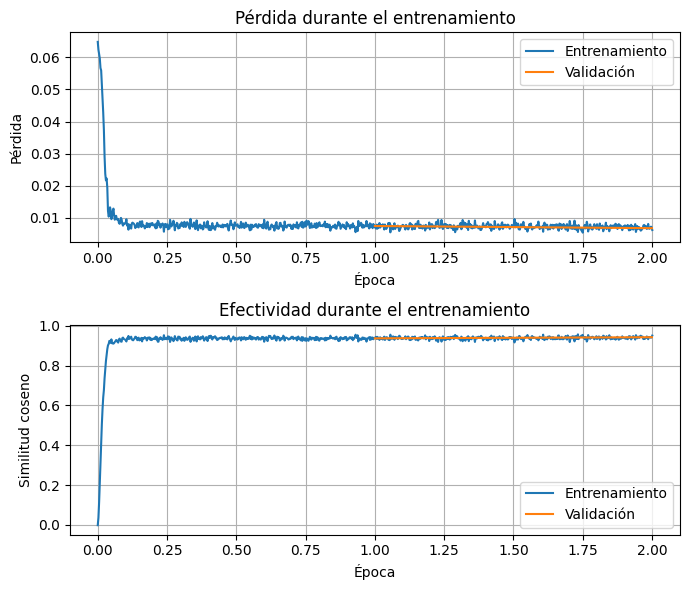

In [ ]:
plt.figure(figsize=(7, 6))

train_epochs = [x / len(train_dataset) * batch_size for x in range(num_epochs * math.ceil(len(train_dataset) / batch_size))]
val_epochs = range(1, num_epochs+1)

plt.subplot(2, 1, 1)
plt.plot(train_epochs, train_cornet_losses, label='Entrenamiento')
plt.plot(val_epochs, val_cornet_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_epochs, train_cosine_similarities, label='Entrenamiento')
plt.plot(val_epochs, val_cosine_similarities, label='Validación')
plt.xlabel('Época')
plt.ylabel('Similitud coseno')
plt.title('Efectividad durante el entrenamiento')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ✍️ TinySpeller

**TinySpeller** es un módulo que transforma la salida de un modelo perceptual como `TinyRecognizer` en una respuesta simbólica explícita —por ejemplo, identificar y "deletrear" la letra reconocida.

Este componente ilustra cómo los sistemas cognitivos pueden **producir** una representación simbólica basada en una entrada sensorial, simulando una respuesta verbal o escrita.

Sus objetivos principales son:

- Convertir activaciones internas en etiquetas simbólicas
- Explorar cómo el sistema "explica" lo que ha percibido
- Conectar percepción con acción o producción simbólica

Es útil para visualizar el paso final de un sistema cognitivo: **la decisión o salida consciente**.

## 🧠 Definición del modelo

Acá se define la arquitectura de la red neuronal. Es una red simple, pero suficiente para experimentar con reconocimiento de palabras. A modo de ejemplo se muestra como luce la arquitectura de una instancia de la red.

In [ ]:
from torch.nn import LSTM

class TinySpeller(Module):
  def __init__(self, tiny_recognizer: TinyRecognizer, tiny_speak: TinySpeak):
    super().__init__()
    self.tiny_recognizer = tiny_recognizer
    self.tiny_speak = tiny_speak

    self.tiny_recognizer.eval()
    for param in self.tiny_recognizer.parameters():
        param.requires_grad = False

  def forward(self, x):
    """
    x: Tensor (batch_size, seq_len, C, H, W)
    """
    batch_size, seq_len, C, H, W = x.size()
    predicted_embeddings = []

    # Embed each letter image in the sequence
    for t in range(seq_len):
      # x_t: (batch_size, C, H, W)
      x_t = x[:, t, :, :, :]
      _, predicted_embedding = self.tiny_recognizer(x_t)
      predicted_embeddings.append(predicted_embedding.unsqueeze(1))  # (batch, 1, dim_embeddings)

    embs = torch.cat(predicted_embeddings, dim=1)  # (batch, seq_len, dim_embeddings)
    lengths = [seq_len] * batch_size
    packed = pack_padded_sequence(
        embs, lengths, batch_first=True, enforce_sorted=False
    )
    return self.tiny_speak(packed)

tiny_speller = TinySpeller(tiny_recognizer, tiny_speak)
tiny_speller = tiny_speller.to(device)
display(tiny_speller)

TinySpeller(
  (tiny_recognizer): TinyRecognizer(
    (cornet): Sequential(
      (V1): CORblock_Z(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (nonlin): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (output): Identity()
      )
      (V2): CORblock_Z(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (output): Identity()
      )
      (V4): CORblock_Z(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (output): Identity()
      )
      (IT): CORblock_Z(
        (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

### 📥 Carga del dataset

En esta parte se crea un conjunto de datos a partir de *Tiny EMNIST*. Este nuevo conjunto de datos permite construir una secuencia de caracteres (imágenes) usando al azar caracteres del *Tiny EMNIST*. A modo de ejemplo se muestra como luce la primer imagen del conjunto de entrenamiento.

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import unicodedata

class TinySequenceDataset(Dataset):
    def __init__(self, root, transform=None, samples_per_word=100, words=words):
        """
        root: path to the root folder with subfolders per letter
        transform: torchvision transforms
        samples_per_word: how many examples per word to generate
        """
        self.words = words
        self.transform = transform
        self.root = root
        self.samples = []

        # Index all letter images
        self.letter_to_images = self._load_letter_image_paths()

        # Build samples
        for word_idx, word in enumerate(words):
            normalized_word = unicodedata.normalize('NFC', word)
            for _ in range(samples_per_word):
                letter_images = []
                for letter in normalized_word:
                    normalized_letter = self._strip_accents(letter)
                    image_path = random.choice(self.letter_to_images[normalized_letter])
                    letter_images.append(image_path)
                self.samples.append((letter_images, word_idx))

    def _strip_accents(self, s):
      return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

    def _load_letter_image_paths(self):
        letter_dict = {}
        for letter in letters:
            folder = os.path.join(self.root, letter)
            images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.JPEG')]
            letter_dict[letter] = images
        return letter_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_paths, label = self.samples[index]
        images = []

        for path in image_paths:
            img = read_image(path).expand(3, -1, -1).float() / 255.0
            if self.transform:
                img = self.transform(img)
            images.append(img)

        # Stack into (seq_len, C, H, W)
        letter_tensor_seq = torch.stack(images, dim=0)
        return letter_tensor_seq, label

dataset = TinySequenceDataset(
    tiny_emnist_path / 'val',
    samples_per_word=1
)

@widgets.interact(i=(0, len(dataset)-1))
def visualizar_dataset(i):
  # Carga la imagen del dataset
  sequence, label = dataset[i]

  # Grafica el resultado
  plt.figure(figsize=(7, 3))
  plt.suptitle(f"Etiqueta={label}, Clase={words[label]}")

  for i, image in enumerate(sequence):
      plt.subplot(1, len(sequence), i+1)
      plt.imshow(image.permute(1, 2, 0).cpu())
      plt.title(f"Imagen {i} ({image.shape[1]}x{image.shape[2]})")

  plt.tight_layout()
  plt.show()

interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

### 🚂 Entrenamiento del modelo

Primero se transforman los datos para que puedan ser utilizados por la red neuronal. Acá se aplica normalización, partición en conjunto de entrenamiento y test, y se ajusta el formato para PyTorch.

Luego se entrena la red sobre el conjunto de datos de entrenamiento, midiendo pérdida y precisión. Este es el paso donde el modelo aprende a reconocer palabras a partir de los patrones visuales en los caracteres.

Época 1/2
Época 2/2


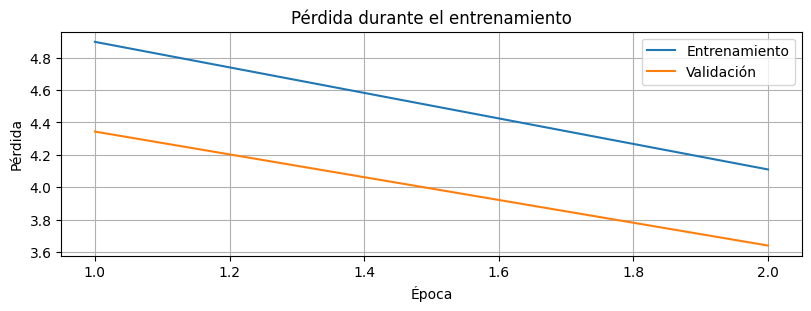

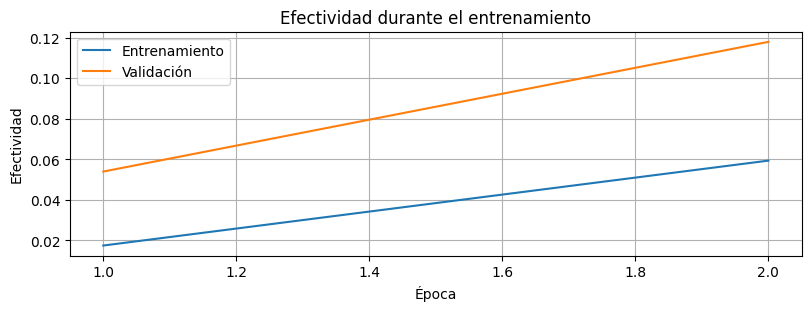

In [ ]:
# Número de épocas a entrenar
num_epochs = 2

# Instancia el criterio para evaluar las pérdidas
criterion = CrossEntropyLoss()

# Instancia el optimizador
optimizer = SGD(tiny_speller.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Instancia el conjunto de entrenamiento
train_dataset = TinySequenceDataset(
  tiny_emnist_path / 'train',
  Compose([
    RandomHorizontalFlip(),
    RandomRotation(30),
    Normalize(mean, std),
  ]),
  samples_per_word=50
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Instancia el conjunto de validación
val_dataset = TinySequenceDataset(
  tiny_emnist_path / 'val',
  Compose([Normalize(mean, std)]),
  samples_per_word=5
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Entrena la red
train_net(tiny_speller, num_epochs, criterion, optimizer, train_loader, val_loader)

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

dataset = TinySequenceDataset(
    tiny_emnist_path / 'val',
    samples_per_word=1
)

@widgets.interact(i=(0, len(dataset)-1))
def visualizar_dataset(i):
  # Carga la imagen del dataset
  sequence, label = dataset[i]
  sequence = sequence.to(device)

  # Grafica el resultado
  plt.figure(figsize=(7, 3))
  plt.suptitle(f"Etiqueta={label}, Clase={words[label]}")

  for i, image in enumerate(sequence):
      plt.subplot(1, len(sequence), i+1)
      plt.imshow(image.permute(1, 2, 0).cpu())
      plt.title(f"Imagen {i} ({image.shape[1]}x{image.shape[2]})")

  plt.tight_layout()
  plt.show()

  tiny_speller.eval()
  with torch.no_grad():
      # Obtenemos la predicción
      logits, _ = tiny_speller(sequence.unsqueeze(0))

  # Calculamos y mostramos la clase predicha
  predicted_label = logits.argmax(dim=1)
  predicted_class = words[predicted_label.item()]
  print(f"Etiqueta: {predicted_label.item()}")
  print(f"Clase: {predicted_class}")

interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

Finalmente, evaluamos que pasa si le pasamos audios de kalulu, en lugar de letras

In [ ]:
tiny_speak = tiny_speller.tiny_speak
tiny_speak = tiny_speak.to(device)

tiny_listener = TinyListener(tiny_speak=tiny_speller.tiny_speak)
tiny_listener = tiny_listener.to(device)

# Evalua el modelo en tiny-kalulu-200
print("Evaluación en tiny-kalulu-200:")
dataset = TinySpeakFolder(tiny_kalulu_path / "val")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
evaluate_net(tiny_listener, CrossEntropyLoss(), loader)

# Evalua el modelo en tiny-phones-200
print("Evaluación en tiny-phones-200:")
dataset = TinySpeakFolder(tiny_phones_path / "val")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
evaluate_net(tiny_listener, CrossEntropyLoss(), loader)

Evaluación en tiny-kalulu-200:


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

val_loss=6.2124
top-1 acc=1.750%
top-3 acc=4.750%
top-5 acc=6.750%
Evaluación en tiny-phones-200:
val_loss=6.5525
top-1 acc=1.750%
top-3 acc=5.250%
top-5 acc=8.000%
